### Load libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import zeros as sci_zeros
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from scipy import zeros as sci_zeros
from scipy.spatial.distance import euclidean

### Define functions

#### `fit_plot_hc`

In [2]:
def fit_plot_hc(df, title='Hierarchical clustering', fig_height=12, label_size=14):
    Y = sch.linkage(df, method='centroid')
    
    fig = plt.figure(figsize=(12,fig_height))
    ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
    
    Z1 = sch.dendrogram(Y, orientation='right')
    labels = skills_list[Z1['leaves']]

    ax1.set_xticks([])
    ax1.set_yticklabels(labels, fontsize=label_size)

    ax1.set_title(title)

    plt.show() # supress prints

#### `plot_bars_with_minmax`

In [3]:
def plot_bars_with_minmax(series_to_plot, plot_title, horizontal=False, color='gray',
                          fig_height=5, fig_width=8,
                          font_color='darkblue',
                          xlabel="", ylabel="", tick_label_size=16,
                          with_minmax=True, with_mean=True,
                          min_border=0.95, max_border=0.99, minmax_width=0.5,
                          sup_line=None):
    """
    function to plot a gray bar chart from a pandas Series,
    plots mean
    highlights bars with minimum values

    Input arguments: series_to_plot -- pandas Series -- Series to plot as a bar chart
                     title          -- string        -- string containing title of the chart
                     with_minmax    -- boolean       -- option to highlight extreme values
                                                        from the Series (default=True)
                     min_border     -- float         -- height limit for black min bar on the plot
                                                        (default=0.95)
                     max_border     -- float         -- height limit for lightgray max bar on the plot
                                                        (default=0.99)
                     minmax_width   -- float         -- width for min and max bars on the plot
                                                        (default=0.5)


    Output:          None, plots and shows bar chart with mean and extremes (optional) highlighted
    """
    font = dict(family='serif', color=font_color, weight='normal', size=16)

    # create figure and axis
    fig, ax = plt.subplots(1, figsize=(fig_width, fig_height))

    if horizontal:
        # plot a horizontal bar chart from input Series
        plt.barh(y=series_to_plot.index,
                 width=series_to_plot,
                 color=color)
        if with_mean:
            # plot mean of the series
            ax.axvline(series_to_plot.mean(), color='black', linestyle='--', linewidth=1)
            ax.text(series_to_plot.mean() * 1.05,
                    0,
                    "Mean: {0:.2f}".format(series_to_plot.mean()),
                    fontsize=16)
        if sup_line:
            ax.axhline(sup_line, color='black', linestyle='--', linewidth=1)
        # optional: highlight the bars with minimum values (if input parameter 'with_min' is True)
        if with_minmax:
            min_se = series_to_plot[series_to_plot == series_to_plot.min()]
            plt.barh(min_se.index,
                     min_se * min_border,
                     minmax_width,
                     color='black')

            max_se = series_to_plot[series_to_plot == series_to_plot.max()]
            plt.barh(max_se.index,
                     max_se * max_border,
                     minmax_width,
                     color='lightgray')
        # set axis parameters
        ax.set_xlabel(xlabel, fontdict=font)
        ax.set_ylabel(ylabel, fontdict=font)
        ax.tick_params('both', labelrotation=1, labelsize=tick_label_size)

    else:
        # plot a bar chart from input Series
        plt.bar(x=series_to_plot.index,
                height=series_to_plot,
                color=color)

        if with_mean:
            # plot mean of the series
            ax.axhline(series_to_plot.mean(), color='black', linestyle='--', linewidth=1)
            ax.text(0,
                    series_to_plot.mean() * 1.01,
                    "Mean: {0:.2f}".format(series_to_plot.mean()))

        # optional: highlight the bars with minimum values (if input parameter 'with_min' is True)
        if with_minmax:
            min_se = series_to_plot[series_to_plot == series_to_plot.min()]
            plt.bar(x=min_se.index,
                    height=min_se * min_border,
                    color='black',
                    width=minmax_width)
            max_se = series_to_plot[series_to_plot == series_to_plot.max()]
            plt.bar(x=max_se.index,
                    height=max_se * max_border,
                    color='lightgray',
                    width=minmax_width)
        if sup_line:
            ax.axvline(sup_line, color='black', linestyle='--', linewidth=1)
        # set axis parameters
        ax.set_xlabel(xlabel, fontdict=font)
        ax.set_xticks(series_to_plot.index)
        ax.set_ylabel(ylabel, fontdict=font)
        ax.tick_params('both', labelrotation=1, labelsize=tick_label_size)

    # set general axis parameters
    ax.set_title(plot_title, fontdict=font)
    ax.grid(False)

    plt.show()
    return


#### `plot_q_parts`

In [4]:
def plot_q_parts(question_list, response_df,
                 question, parts,
                 comment='', return_subset=False, tick_label_size=12,
                 fig_height=5, fig_width=8,
                 with_minmax=True):
    """
    a function to plot results of a question from Kaggle survey
    that are stored in a range of columns
    """
    question_start_col = question + '_Part_1'
    question_last_col = question + '_Part_' + str(parts)

    question_subset = response_df.loc[:, question_start_col:question_last_col]
    answer_categories = []
    for column in question_subset.columns:
        answer_categories.append(question_list.loc[column].split(' - ')[-1])

    question_subset.columns = answer_categories

    series_to_plot = question_subset.count().sort_values(ascending=False)

    title = question + ': ' + question_list[question + '_Part_1'].split(' - ')[0] + '\n' + comment

    plot_bars_with_minmax(series_to_plot, title, horizontal=True,
                          with_mean=False,
                          tick_label_size=tick_label_size,
                          fig_height=fig_height, fig_width=fig_width,
                          with_minmax=with_minmax)

    if return_subset:
        return series_to_plot
    else:
        return


## Hierarchical clustering of the scraped Indeed.ca data

### Read the scraped Indeed.ca data

#### Managerial job posts skills mentioned

In [5]:
# set file path
mng_skills_indeed_path = 'ds_managerial_skills.csv'

# read the .csv file
df_mng = pd.read_csv(mng_skills_indeed_path)

# select only the skill columns
df_mng = df_mng.iloc[:, 6:]

df_mng.head()

,AWS Cloud,Algebra,Azure,Big Data,C/C++,Data Mining/Analytics,DevOps,Excel,GCP,Git,...,Visualisation,agile,consulting,decision making,leadership,management,presentation,problem solving,project_management,xml
0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,1,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### Technical job posts skills mentioned

In [6]:
# set file path
tech_skills_indeed_path = 'ds_tech_skills.csv'

# read the .csv file
df_tech = pd.read_csv(tech_skills_indeed_path)

# select only the skill columns
df_tech = df_tech.iloc[:, 6:]

df_tech.head()

,AWS Cloud,Algebra,Azure,Big Data,C/C++,Data Mining/Analytics,DevOps,Excel,GCP,Git,...,Visualisation,agile,consulting,decision making,leadership,management,presentation,problem solving,project_management,xml
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get a list with skill names from DF columns

In [7]:
# get the list of skill names
skills_list = df_mng.columns.values
skills_list

array(['AWS Cloud', 'Algebra', 'Azure', 'Big Data', 'C/C++',
       'Data Mining/Analytics', 'DevOps', 'Excel', 'GCP', 'Git',
       'Google Cloud', 'IBM', 'Jason', 'Java', 'MATLAB',
       'Machine Learning', 'Mathematics', 'NLP', 'Neural Networks',
       'Operations research', 'Oracle', 'Probability', 'Python', 'R',
       'SAS', 'SDLC', 'SPSS', 'SQL/databases', 'Scala', 'Stata',
       'Statistics', 'Support Vector Machines', 'Team building',
       'Visualisation', 'agile', 'consulting', 'decision making',
       'leadership', 'management', 'presentation', 'problem solving',
       'project_management', 'xml'], dtype=object)

### Workflow sample -- number of job posts that mention both 'Big data' and 'Scala'

In [8]:
mask1 = df_tech['Big Data'] == 1
mask2 = df_tech['Scala'] == 1
len(df_tech[mask1 & mask2])

17

### Generate of matrix of skill co-occurances

Record number of posts where both skills get mentioned for each pair of skills

In [9]:
# empty matrix is fill
num_skills = len(df_mng.columns)
D_mng = sci_zeros([num_skills, num_skills])

# Find all element wise temp differences
for i in range(num_skills):
    for j in range(num_skills):
        mask1 = df_mng.iloc[:, i] == 1
        mask2 = df_mng.iloc[:, j] == 1
        D_mng[i,j] = len(df_mng[mask1 & mask2])

In [10]:
# empty matrix is fill
num_skills = len(df_tech.columns)
D_tech = sci_zeros([num_skills, num_skills])

# Find all element wise temp differences
for i in range(num_skills):
    for j in range(num_skills):
        mask1 = df_tech.iloc[:, i] == 1
        mask2 = df_tech.iloc[:, j] == 1
        D_tech[i,j] = len(df_tech[mask1 & mask2])

* Recorded matrix of counts per skill pair. 

* Diagonal is skill "paired" with itself, simply represents total number of job posts where that individual skill is mentioned.

In [11]:
D_mng

array([[ 15.,   0.,   9., ...,   2.,   2.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  9.,   0.,  19., ...,   3.,   3.,   0.],
       ...,
       [  2.,   0.,   3., ..., 137.,  24.,   1.],
       [  2.,   0.,   3., ...,  24., 134.,   0.],
       [  0.,   0.,   0., ...,   1.,   0.,   1.]])

### Normalize the generated matrix of skill co-occurances

In [12]:
D_mng_norm = normalize(D_mng)
D_mng_norm

array([[0.43537742, 0.        , 0.26122645, ..., 0.05805032, 0.05805032,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21841058, 0.        , 0.461089  , ..., 0.07280353, 0.07280353,
        0.        ],
       ...,
       [0.0071657 , 0.        , 0.01074855, ..., 0.49085029, 0.08598837,
        0.00358285],
       [0.00667606, 0.        , 0.01001409, ..., 0.08011268, 0.44729581,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.35355339, 0.        ,
        0.35355339]])

### Fit an Hierarchical clustering model on skills parsed from job postings scraped from Indeed.ca

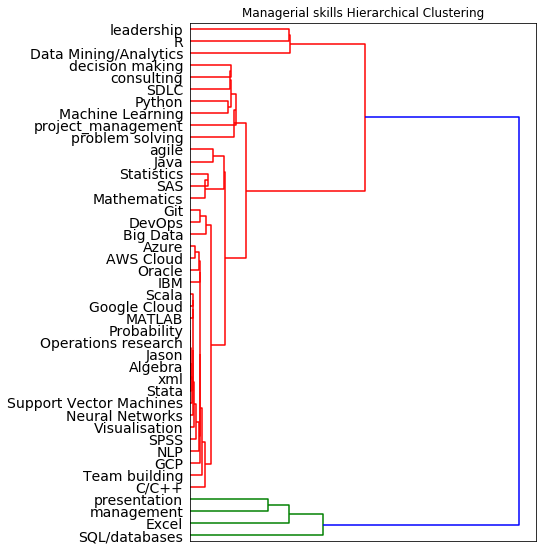

In [13]:
title = 'Managerial skills Hierarchical Clustering'
fit_plot_hc(D_mng, title=title)

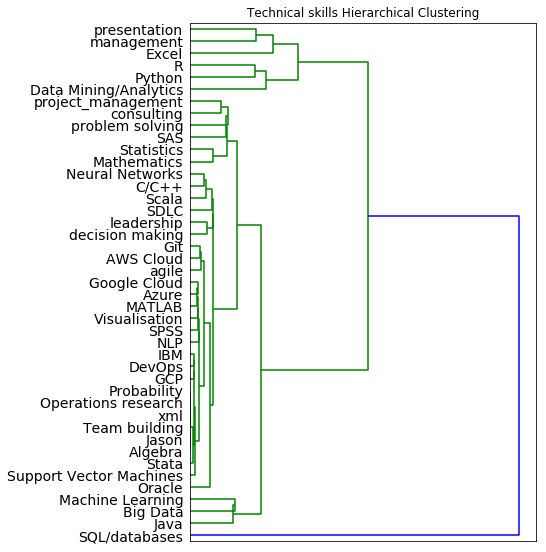

In [14]:
title = 'Technical skills Hierarchical Clustering'
fit_plot_hc(D_tech, title=title)

## Hierarchical clustering of Kaggle survey data

### Read the Kaggle survey data

In [44]:
kaggle_survey_path = 'kaggle-survey-2018/multipleChoiceResponses.csv'

question_list = pd.read_csv(kaggle_survey_path, nrows=1)
question_list = question_list.iloc[0]

responses_only = pd.read_csv(kaggle_survey_path, low_memory=False)
responses_only = responses_only.drop(0)

responses_only['Time from Start to Finish (seconds)'] = \
    responses_only['Time from Start to Finish (seconds)'].astype('int')

responses_only['Time from Start to Finish (minutes)'] = \
    responses_only['Time from Start to Finish (seconds)'] // 60

# this would only work if column Q9 contains numerical info, original Kaggle survey has it as categories
#responses_only['Q9'] = pd.to_numeric(responses_only['Q9'], errors='raise')

print("{0:,} rows in the DataFrame.".format(len(responses_only)))
responses_only.head(1)

23,859 rows in the DataFrame.


,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,Time from Start to Finish (minutes)
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,11


### Generate the subset of relevant columns from the Kaggle survey

In [46]:
select_questions_list = ['Q11', 'Q14', 'Q15', 'Q16', 'Q19', 'Q21', 'Q31', 'Q47']

In [47]:
for question in select_questions_list:
    # get a list of columns that contain this question
    question_cols = [col for col in responses_only.columns if question in col]
    # drop the last element from the list (free text)
    question_cols.pop()
    question_cols.pop()
    question_cols.pop()
    print(question_cols)

['Q11_Part_1', 'Q11_Part_2', 'Q11_Part_3', 'Q11_Part_4', 'Q11_Part_5']
['Q14_Part_1', 'Q14_Part_2', 'Q14_Part_3', 'Q14_Part_4', 'Q14_Part_5', 'Q14_Part_6', 'Q14_Part_7', 'Q14_Part_8', 'Q14_Part_9']
['Q15_Part_1', 'Q15_Part_2', 'Q15_Part_3', 'Q15_Part_4', 'Q15_Part_5']
['Q16_Part_1', 'Q16_Part_2', 'Q16_Part_3', 'Q16_Part_4', 'Q16_Part_5', 'Q16_Part_6', 'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_9', 'Q16_Part_10', 'Q16_Part_11', 'Q16_Part_12', 'Q16_Part_13', 'Q16_Part_14', 'Q16_Part_15', 'Q16_Part_16']
['Q19_Part_1', 'Q19_Part_2', 'Q19_Part_3', 'Q19_Part_4', 'Q19_Part_5', 'Q19_Part_6', 'Q19_Part_7', 'Q19_Part_8', 'Q19_Part_9', 'Q19_Part_10', 'Q19_Part_11', 'Q19_Part_12', 'Q19_Part_13', 'Q19_Part_14', 'Q19_Part_15', 'Q19_Part_16', 'Q19_Part_17']
['Q21_Part_1', 'Q21_Part_2', 'Q21_Part_3', 'Q21_Part_4', 'Q21_Part_5', 'Q21_Part_6', 'Q21_Part_7', 'Q21_Part_8', 'Q21_Part_9', 'Q21_Part_10', 'Q21_Part_11']
['Q31_Part_1', 'Q31_Part_2', 'Q31_Part_3', 'Q31_Part_4', 'Q31_Part_5', 'Q31_Part_6', 'Q31_Part_

In [48]:
select_questions_df = pd.DataFrame()
min_records = 22000

iteration = 0
for question in select_questions_list:
    # get a list of columns that contain this question
    question_cols = [col for col in responses_only.columns if question in col]
    # drop the last three elements from the list (free text, None, Other answer options)
    question_cols.pop()
    question_cols.pop()
    question_cols.pop()
    question_subset = responses_only[question_cols].copy()
    answer_categories = []
    for column in question_subset.columns:
        answer_categories.append(question_list.loc[column].split(' - ')[-1])
        question_subset[column] = question_subset[column].str.replace(re.escape(answer_categories[-1]), 
                                                                                     '1')
        question_subset[column] = question_subset[column].fillna(0)
        if question_subset[column].value_counts().loc[0] > min_records:
            question_subset = question_subset.drop(column, axis=1)
            answer_categories.pop()
        else:
            try:
                question_subset[column] = question_subset[column].astype('int')
            except ValueError:
                print(column, "could not get converted to 'int'")
        
    question_subset.columns = answer_categories
    iteration += 1
    if iteration ==1:
        select_questions_df = question_subset
    else:
        select_questions_df = pd.concat([select_questions_df, question_subset], axis=1)

select_questions_df.head()

,Analyze and understand data to influence product or business decisions,Build and/or run a machine learning service that operationally improves my product or workflows,"Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Build prototypes to explore applying machine learning to new areas,Do research that advances the state of the art of machine learning,Kaggle Kernels,Google Colab,JupyterHub/Binder,Google Cloud Platform (GCP),Amazon Web Services (AWS),...,Time Series Data,Examine individual model coefficients,Examine feature correlations,Examine feature importances,Plot decision boundaries,Create partial dependence plots,Dimensionality reduction techniques,Plot predicted vs. actual results,Print out a decision tree,Sensitivity analysis/perturbation importance
1,1,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0
4,0,0,0,0,0,1,1,0,1,1,...,1,0,1,1,1,0,0,1,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [49]:
select_questions_df.columns

Index(['Analyze and understand data to influence product or business decisions',
       'Build and/or run a machine learning service that operationally improves my product or workflows',
       'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
       'Build prototypes to explore applying machine learning to new areas',
       'Do research that advances the state of the art of machine learning',
       'Kaggle Kernels', 'Google Colab', 'JupyterHub/Binder',
       'Google Cloud Platform (GCP)', 'Amazon Web Services (AWS)',
       'Microsoft Azure', 'Python', 'R', 'SQL', 'Bash', 'Java',
       'Javascript/Typescript', 'C/C++', 'MATLAB', 'Scikit-Learn',
       'TensorFlow', 'Keras', 'PyTorch', 'Spark MLlib', 'Caret', 'Xgboost',
       'randomForest', 'lightgbm', 'ggplot2', 'Matplotlib', 'Shiny', 'D3',
       'Plotly', 'Bokeh', 'Seaborn', 'Categorical Data', 'Geospatial Data',
       'Image Data', 'Numerical Data', 'Sensor Da

### Get a list with skill names from DF columns

In [50]:
# get the list of skill names
skills_list = select_questions_df.columns.values
print(len(skills_list), "skills in the list")
skills_list

52 skills in the list


array(['Analyze and understand data to influence product or business decisions',
       'Build and/or run a machine learning service that operationally improves my product or workflows',
       'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
       'Build prototypes to explore applying machine learning to new areas',
       'Do research that advances the state of the art of machine learning',
       'Kaggle Kernels', 'Google Colab', 'JupyterHub/Binder',
       'Google Cloud Platform (GCP)', 'Amazon Web Services (AWS)',
       'Microsoft Azure', 'Python', 'R', 'SQL', 'Bash', 'Java',
       'Javascript/Typescript', 'C/C++', 'MATLAB', 'Scikit-Learn',
       'TensorFlow', 'Keras', 'PyTorch', 'Spark MLlib', 'Caret',
       'Xgboost', 'randomForest', 'lightgbm', 'ggplot2', 'Matplotlib',
       'Shiny', 'D3', 'Plotly', 'Bokeh', 'Seaborn', 'Categorical Data',
       'Geospatial Data', 'Image Data', 'Numerical Data', 'Sensor Da

### Generate of matrix of skill co-occurances

Record number of posts where both skills get mentioned for each pair of skills

In [51]:
# empty matrix is fill
num_skills = len(select_questions_df.columns)
D = sci_zeros([num_skills, num_skills])

# Find all element wise temp differences
for i in range(num_skills):
    for j in range(num_skills):
        mask1 = select_questions_df.iloc[:, i] == 1
        mask2 = select_questions_df.iloc[:, j] == 1
        D[i,j] = len(select_questions_df[mask1 & mask2])

In [52]:
D[0]

array([9532., 3559., 3759., 4504., 2499., 3033., 1631., 2594., 2485.,
       4146., 2198., 7477., 4076., 4965., 1430., 1490., 1441., 1389.,
       1013., 6167., 4696., 3948., 1762., 1301., 1547., 3425., 3662.,
       1266., 4663., 6357., 1875., 1336., 3373., 1230., 4244., 4907.,
       1469., 2076., 6258., 1298., 4478., 4636., 4785., 2337., 3200.,
       3593., 1919., 1170., 2473., 4351., 2231., 1922.])

* Recorded matrix of counts per skill pair. 

* Diagonal is skill "paired" with itself, simply represents total number of job posts where that individual skill is mentioned.

### Normalize the generated matrix of skill co-occurances

In [56]:
D_norm = normalize(D)
D_norm[0]

array([0.35807872, 0.13369725, 0.14121044, 0.16919708, 0.09387733,
       0.11393755, 0.06127008, 0.0974461 , 0.09335141, 0.15574847,
       0.08256998, 0.28088068, 0.15311885, 0.18651499, 0.05371932,
       0.05597328, 0.05413255, 0.05217912, 0.03805432, 0.23166927,
       0.17640974, 0.14831041, 0.06619122, 0.04887331, 0.05811454,
       0.12866341, 0.13756654, 0.0475585 , 0.17517007, 0.2388068 ,
       0.07043617, 0.05018812, 0.12670998, 0.04620613, 0.15942993,
       0.18433616, 0.05518439, 0.07798693, 0.23508777, 0.04876061,
       0.16822036, 0.17415579, 0.17975311, 0.08779165, 0.12021107,
       0.13497449, 0.07208908, 0.04395217, 0.09290062, 0.16344949,
       0.08380965, 0.07220177])

### Fit and plot an Hierarchical clustering model on Kaggle survey data

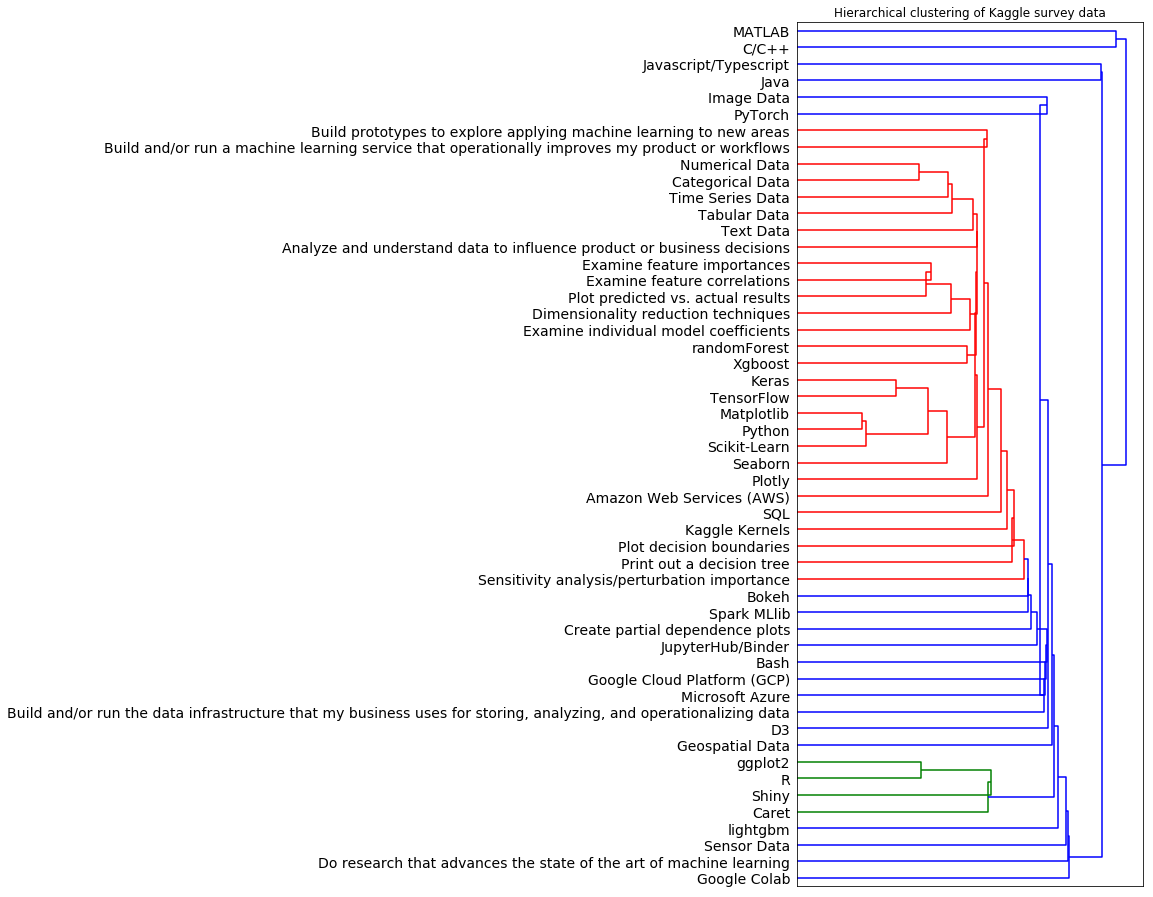

In [61]:
title = "Hierarchical clustering of Kaggle survey data"
fit_plot_hc(D_norm, title=title, fig_height=20)